## Package-Installation & Imports

In [1]:
import os
import pandas as pd
import numpy as np

# EDA
from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Modell-Vorbereitung
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Modellevaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, accuracy_score, roc_curve, auc

# Modelle
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


## Datenimport

Quelle der Daten: https://www.kaggle.com/datasets/nelgiriyewithana/credit-card-fraud-detection-dataset-2023/data

In [2]:
FILEPATH_DATA = os.path.join("input", "creditcard_2023.csv")

df = pd.read_csv(FILEPATH_DATA, low_memory=False)

df.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


## Explorative Datenanalyse (EDA)

In [3]:
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile.to_file(os.path.join("output", "profiling-report-creditcard-fraud.html"))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      568630 non-null  int64  
 1   V1      568630 non-null  float64
 2   V2      568630 non-null  float64
 3   V3      568630 non-null  float64
 4   V4      568630 non-null  float64
 5   V5      568630 non-null  float64
 6   V6      568630 non-null  float64
 7   V7      568630 non-null  float64
 8   V8      568630 non-null  float64
 9   V9      568630 non-null  float64
 10  V10     568630 non-null  float64
 11  V11     568630 non-null  float64
 12  V12     568630 non-null  float64
 13  V13     568630 non-null  float64
 14  V14     568630 non-null  float64
 15  V15     568630 non-null  float64
 16  V16     568630 non-null  float64
 17  V17     568630 non-null  float64
 18  V18     568630 non-null  float64
 19  V19     568630 non-null  float64
 20  V20     568630 non-null  float64
 21  V21     56

In [5]:
df = df.drop(columns='id', axis=1)

In [6]:
print(df['Class'].value_counts())

Class
0    284315
1    284315
Name: count, dtype: int64


## Hilfsfunktion(en)

### Confusion Matrix

In [7]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Modellevaluation

In [8]:
def evaluate_model(model, X_test, X_train, y_train, y_test, y_pred):
    accuracy_train = model.score(X_train, y_train)
    accuracy_test = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    return {'Accuracy on train': accuracy_train, 'Accuracy on test': accuracy_test, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'Roc Auc': roc_auc}

def print_metrics(metrics):
    print("Accuracy on training set:", metrics['Accuracy on train'])
    print("Accuracy on test set:", metrics['Accuracy on test'])
    print("Precision:", metrics['Precision'])
    print("Recall:", metrics['Recall'])
    print("F1-Score:", metrics['F1 Score'])
    print("ROC-AUC:", metrics['Roc Auc'])

## Vorbereitung des Datenmodells

In [9]:
y = df['Class']
X = df.drop('Class', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, stratify=y, random_state=304)

In [10]:
# Überprüfung der Verteilung
print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

# Verteilung der Klassen in y_train und y_test
print(f"Verteilung in y_train:")
print(y_train.value_counts())

print(f"\nVerteilung in y_test:")
print(y_test.value_counts())

X train: (454904, 29)
y train: (454904,)
X test: (113726, 29)
y test: (113726,)
Verteilung in y_train:
Class
0    227452
1    227452
Name: count, dtype: int64

Verteilung in y_test:
Class
0    56863
1    56863
Name: count, dtype: int64


In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modell-Training

### LogisticRegression

Accuracy on training set: 0.964904683185903
Accuracy on test set: 0.9652234317570301
Precision: 0.9786321693504614
Recall: 0.9512160807555
F1-Score: 0.9647293838566701
ROC-AUC: 0.9652234317570301
Confusion matrix, without normalization
[[55682  1181]
 [ 2774 54089]]
Normalized confusion matrix
[[0.98 0.02]
 [0.05 0.95]]


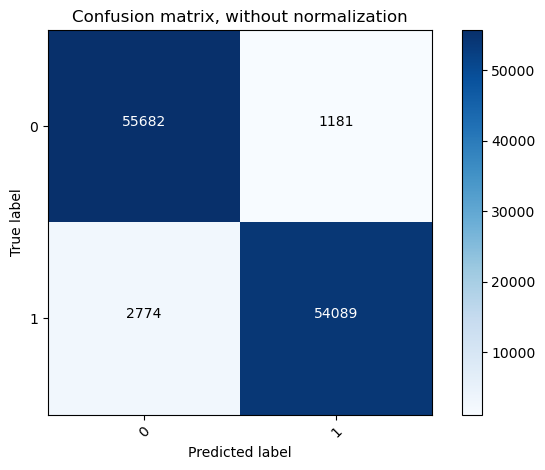

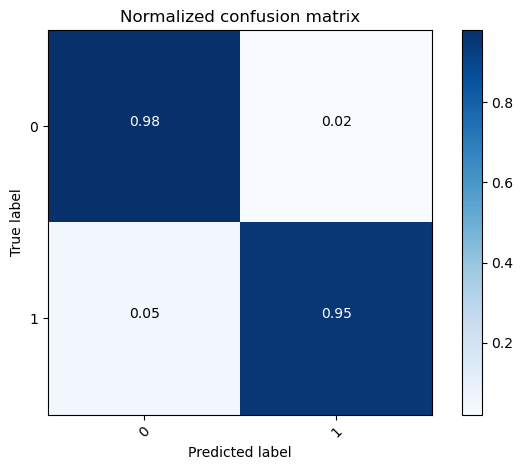

In [12]:
lr = LogisticRegression(random_state=304)
model_lr = lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

lr_metrics = evaluate_model(model_lr, X_test, X_train, y_train, y_test, y_pred_lr)
print_metrics(lr_metrics)

lr_cnf_matrix = confusion_matrix(y_test, y_pred_lr)

plt.figure()
plot_confusion_matrix(lr_cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, without normalization')
plt.savefig(os.path.join("output", "confusion_matrix_lr"))
# With normalization
plt.figure()
plot_confusion_matrix(lr_cnf_matrix, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')
plt.savefig(os.path.join("output", "confusion_matrix_lr_normalized"))
plt.show()

### Extreme Gradient Boost

Accuracy on training set: 0.9999934052019767
Accuracy on test set: 0.9997450011430983
Precision: 0.9994902622512831
Recall: 1.0
F1-Score: 0.9997450661509384
ROC-AUC: 0.9997450011430984
Confusion matrix, without normalization
[[56834    29]
 [    0 56863]]
Normalized confusion matrix
[[9.99e-01 5.10e-04]
 [0.00e+00 1.00e+00]]


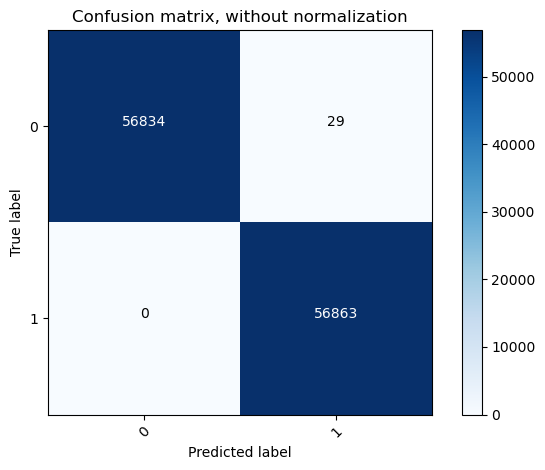

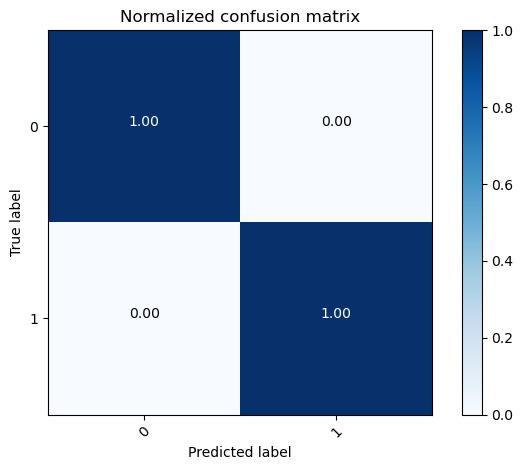

In [13]:
xgb = XGBClassifier(random_state=304)
model_xgb = xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

xgb_metrics = evaluate_model(model_xgb, X_test, X_train, y_train, y_test, y_pred_xgb)
print_metrics(xgb_metrics)

xgb_cnf_matrix = confusion_matrix(y_test, y_pred_xgb)

plt.figure()
plot_confusion_matrix(xgb_cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, without normalization')
plt.savefig(os.path.join("output", "confusion_matrix_xgb"))
# With normalization
plt.figure()
plot_confusion_matrix(xgb_cnf_matrix, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')
plt.savefig(os.path.join("output", "confusion_matrix_xgb_normalized"))
plt.show()

### Naive Bayes

Accuracy on training set: 0.9189433374953836
Accuracy on test set: 0.9182157114468108
Precision: 0.974538053238616
Recall: 0.858871322300969
F1-Score: 0.9130560774745974
ROC-AUC: 0.9182157114468107
Confusion matrix, without normalization
[[55587  1276]
 [ 8025 48838]]
Normalized confusion matrix
[[0.98 0.02]
 [0.14 0.86]]


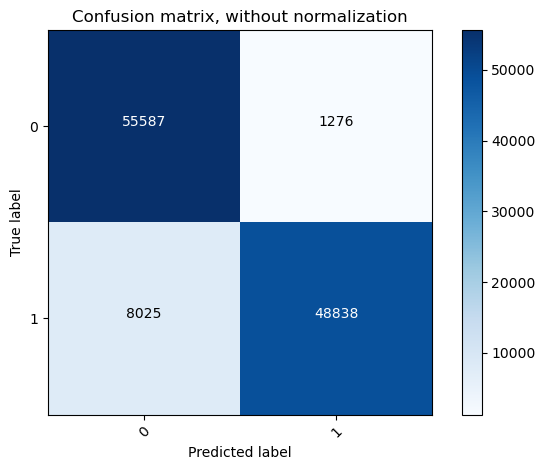

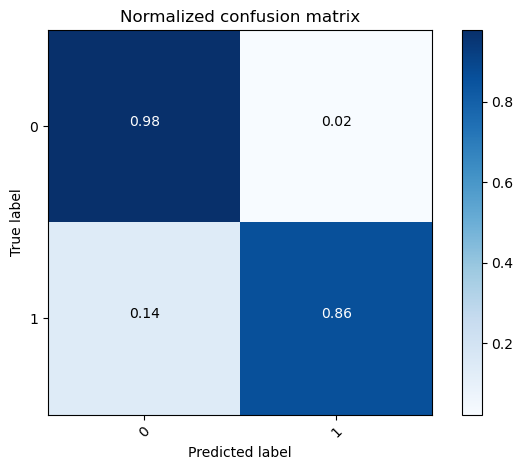

In [14]:
nb = GaussianNB()
model_nb = nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

nb_metrics = evaluate_model(model_nb, X_test, X_train, y_train, y_test, y_pred_nb)
print_metrics(nb_metrics)

nb_cnf_matrix = confusion_matrix(y_test, y_pred_nb)

plt.figure()
plot_confusion_matrix(nb_cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, without normalization')
plt.savefig(os.path.join("output", "confusion_matrix_nb"))
# With normalization
plt.figure()
plot_confusion_matrix(nb_cnf_matrix, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')
plt.savefig(os.path.join("output", "confusion_matrix_nb_normalized"))
plt.show()

### Random Forest

Accuracy on training set: 0.9553466225841056
Accuracy on test set: 0.9547860647521236
Precision: 0.9933044655971616
Recall: 0.9157448604540738
F1-Score: 0.9529491426166206
ROC-AUC: 0.9547860647521236
Confusion matrix, without normalization
[[56512   351]
 [ 4791 52072]]
Normalized confusion matrix
[[0.99 0.01]
 [0.08 0.92]]


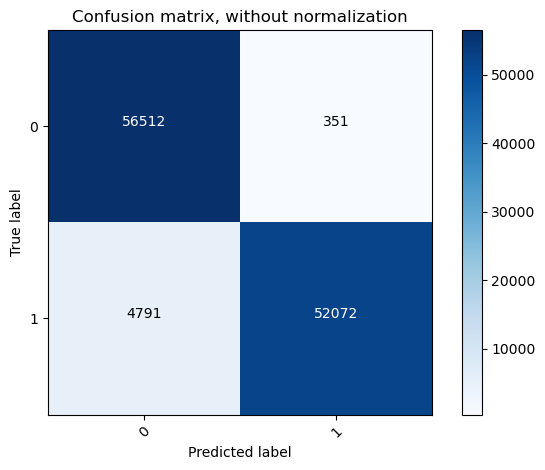

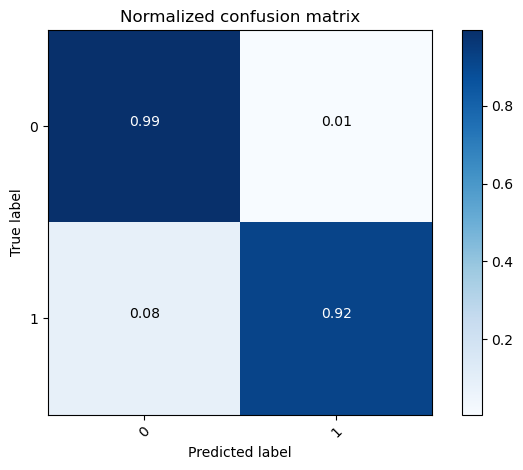

In [15]:
rf = RandomForestClassifier(n_estimators=20, max_depth=5, random_state=304)
model_rf = rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rf_metrics = evaluate_model(model_rf, X_test, X_train, y_train, y_test, y_pred_rf)
print_metrics(rf_metrics)

rf_cnf_matrix = confusion_matrix(y_test, y_pred_rf)

plt.figure()
plot_confusion_matrix(rf_cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, without normalization')
plt.savefig(os.path.join("output", "confusion_matrix_rf"))
# With normalization
plt.figure()
plot_confusion_matrix(rf_cnf_matrix, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')
plt.savefig(os.path.join("output", "confusion_matrix_rf_normalized"))
plt.show()


### Decision Tree

Accuracy on training set: 1.0
Accuracy on test set: 0.9981534565534707
Precision: 0.997488540367762
Recall: 0.9988217294198336
F1-Score: 0.9981546897242579
ROC-AUC: 0.9981534565534707
Confusion matrix, without normalization
[[56720   143]
 [   67 56796]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


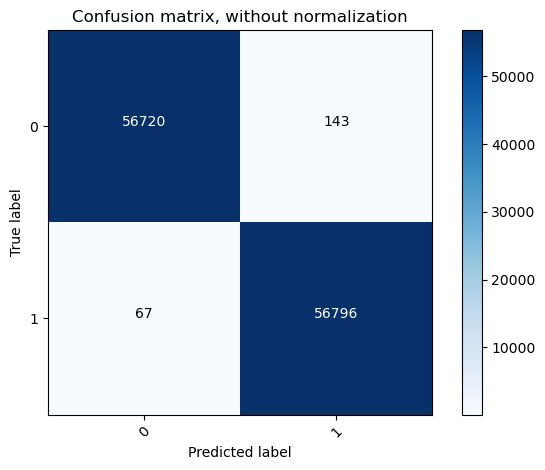

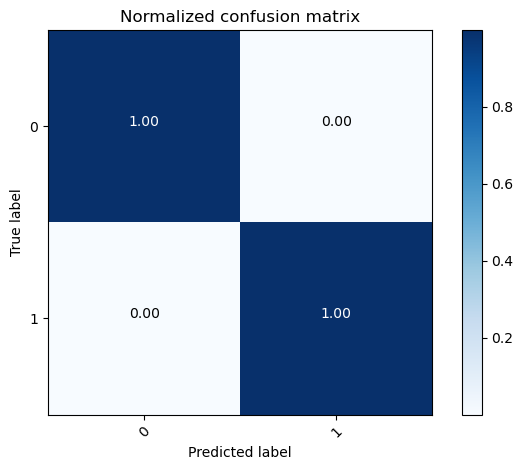

In [16]:
dt = DecisionTreeClassifier(random_state=304)
model_dt = dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

dt_metrics = evaluate_model(model_dt, X_test, X_train, y_train, y_test, y_pred_dt)
print_metrics(dt_metrics)

dt_cnf_matrix = confusion_matrix(y_test, y_pred_dt)

plt.figure()
plot_confusion_matrix(dt_cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, without normalization')
plt.savefig(os.path.join("output", "confusion_matrix_dt"))
# With normalization
plt.figure()
plot_confusion_matrix(dt_cnf_matrix, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')
plt.savefig(os.path.join("output", "confusion_matrix_dt_normalized"))
plt.show()


### K-Nearest Neighbors

Accuracy on training set: 0.998595308021033
Accuracy on test set: 0.9980215605930043
Precision: 0.9960760957152367
Recall: 0.9999824138719379
F1-Score: 0.9980254324302978
ROC-AUC: 0.9980215605930042
Confusion matrix, without normalization
[[56639   224]
 [    1 56862]]
Normalized confusion matrix
[[9.96e-01 3.94e-03]
 [1.76e-05 1.00e+00]]


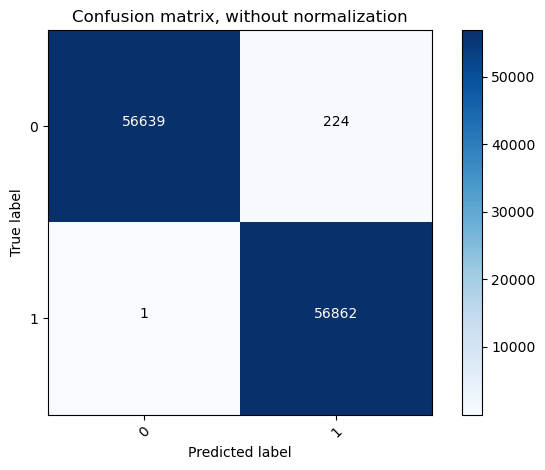

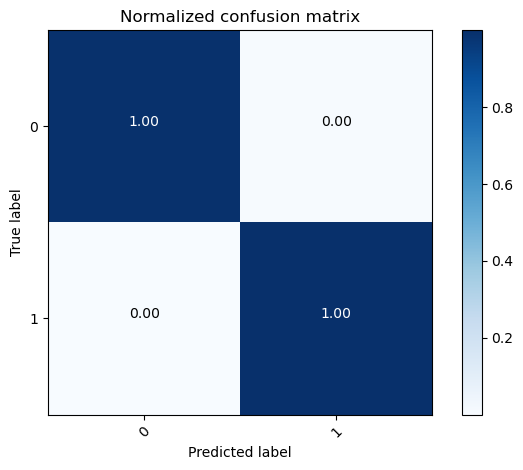

In [17]:
knn = KNeighborsClassifier()
model_knn = knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

knn_metrics = evaluate_model(model_knn, X_test, X_train, y_train, y_test, y_pred_knn)
print_metrics(knn_metrics)

knn_cnf_matrix = confusion_matrix(y_test, y_pred_knn)

plt.figure()
plot_confusion_matrix(knn_cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, without normalization')
plt.savefig(os.path.join("output", "confusion_matrix_knn"))
# With normalization
plt.figure()
plot_confusion_matrix(knn_cnf_matrix, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')
plt.savefig(os.path.join("output", "confusion_matrix_knn_normalized"))
plt.show()

### Künstlichen neuronales Netzwerk

Accuracy on training set: 0.9998681040395336
Accuracy on test set: 0.9996834496948807
Precision: 0.9993672999525475
Recall: 1.0
F1-Score: 0.9996835498672667
ROC-AUC: 0.9996834496948807
Confusion matrix, without normalization
[[56827    36]
 [    0 56863]]
Normalized confusion matrix
[[9.99e-01 6.33e-04]
 [0.00e+00 1.00e+00]]


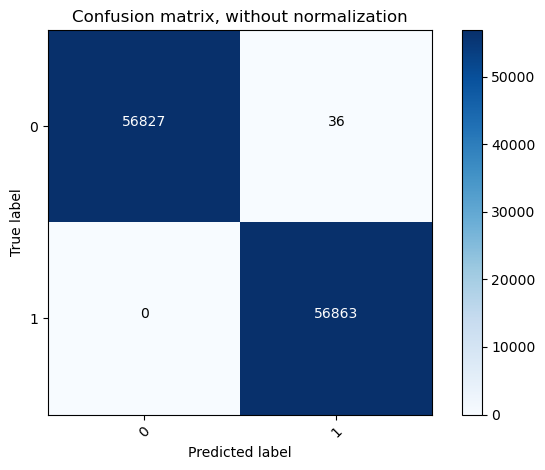

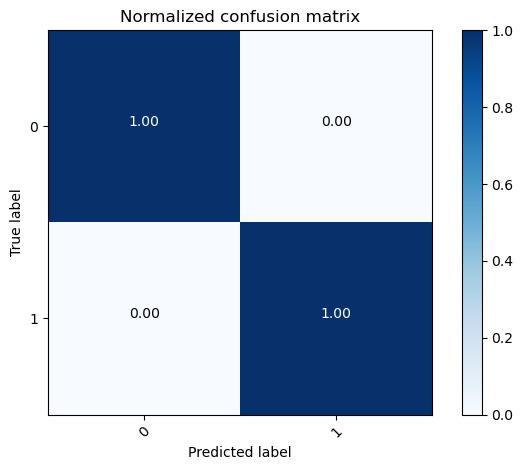

In [18]:
mlp = MLPClassifier(random_state=304)
model_mlp = mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

mlp_metrics = evaluate_model(model_mlp, X_test, X_train, y_train, y_test, y_pred_mlp)
print_metrics(mlp_metrics)

mlp_cnf_matrix = confusion_matrix(y_test, y_pred_mlp)

plt.figure()
plot_confusion_matrix(mlp_cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, without normalization')
plt.savefig(os.path.join("output", "confusion_matrix_mlp"))
# With normalization
plt.figure()
plot_confusion_matrix(mlp_cnf_matrix, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')
plt.savefig(os.path.join("output", "confusion_matrix_mlp_normalized"))
plt.show()

## Modellvergleich

### XGB Feature Importance

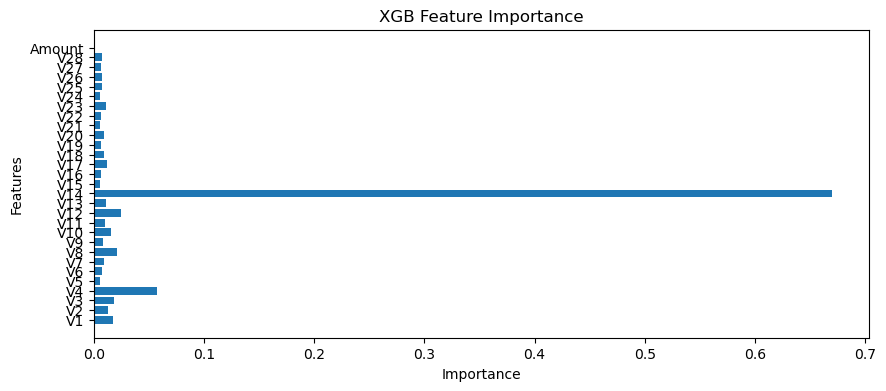

In [19]:
xgbfeatures = pd.DataFrame({'Feature': ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13',
                                        'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'], 'Importance': xgb.feature_importances_})
plt.figure(figsize=(10, 4))
plt.title("XGB Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.barh(xgbfeatures['Feature'], xgbfeatures['Importance'])
plt.savefig(os.path.join("output", "xgb_feature_importance"))
plt.show()

### Vergleich von Evaluations-Metriken

In [20]:
df_metrics = pd.DataFrame({
    'Model': [
        'Logistic Regression', 
        'Extreme Gradient Boost', 
        'Naive Bayes', 
        'Random Forest', 
        'Decision Tree', 
        'K-Nearest Neighbors', 
        'Künstliches Neuronales Netzwerk'
    ],
    'Accuracy on Train': [lr_metrics['Accuracy on train'], xgb_metrics['Accuracy on train'], nb_metrics['Accuracy on train'], rf_metrics['Accuracy on train'], dt_metrics['Accuracy on train'], knn_metrics['Accuracy on train'], mlp_metrics['Accuracy on train']],
    'Accuracy on Test': [lr_metrics['Accuracy on test'], xgb_metrics['Accuracy on test'], nb_metrics['Accuracy on test'], rf_metrics['Accuracy on test'], dt_metrics['Accuracy on test'], knn_metrics['Accuracy on test'], mlp_metrics['Accuracy on test']],
    'Precision': [lr_metrics['Precision'], xgb_metrics['Precision'], nb_metrics['Precision'], rf_metrics['Precision'], dt_metrics['Precision'], knn_metrics['Precision'], mlp_metrics['Precision']],
    'Recall': [lr_metrics['Recall'], xgb_metrics['Recall'], nb_metrics['Recall'], rf_metrics['Recall'], dt_metrics['Recall'], knn_metrics['Recall'], mlp_metrics['Recall']],
    'F1 Score': [lr_metrics['F1 Score'], xgb_metrics['F1 Score'], nb_metrics['F1 Score'], rf_metrics['F1 Score'], dt_metrics['F1 Score'], knn_metrics['F1 Score'], mlp_metrics['F1 Score']]
})

df_metrics = df_metrics.round(2)

print(df_metrics)
df_metrics.to_csv(os.path.join("output", "metrics_comparison.csv"))

                             Model  Accuracy on Train  Accuracy on Test  \
0              Logistic Regression               0.96              0.97   
1           Extreme Gradient Boost               1.00              1.00   
2                      Naive Bayes               0.92              0.92   
3                    Random Forest               0.96              0.95   
4                    Decision Tree               1.00              1.00   
5              K-Nearest Neighbors               1.00              1.00   
6  Künstliches Neuronales Netzwerk               1.00              1.00   

   Precision  Recall  F1 Score  
0       0.98    0.95      0.96  
1       1.00    1.00      1.00  
2       0.97    0.86      0.91  
3       0.99    0.92      0.95  
4       1.00    1.00      1.00  
5       1.00    1.00      1.00  
6       1.00    1.00      1.00  


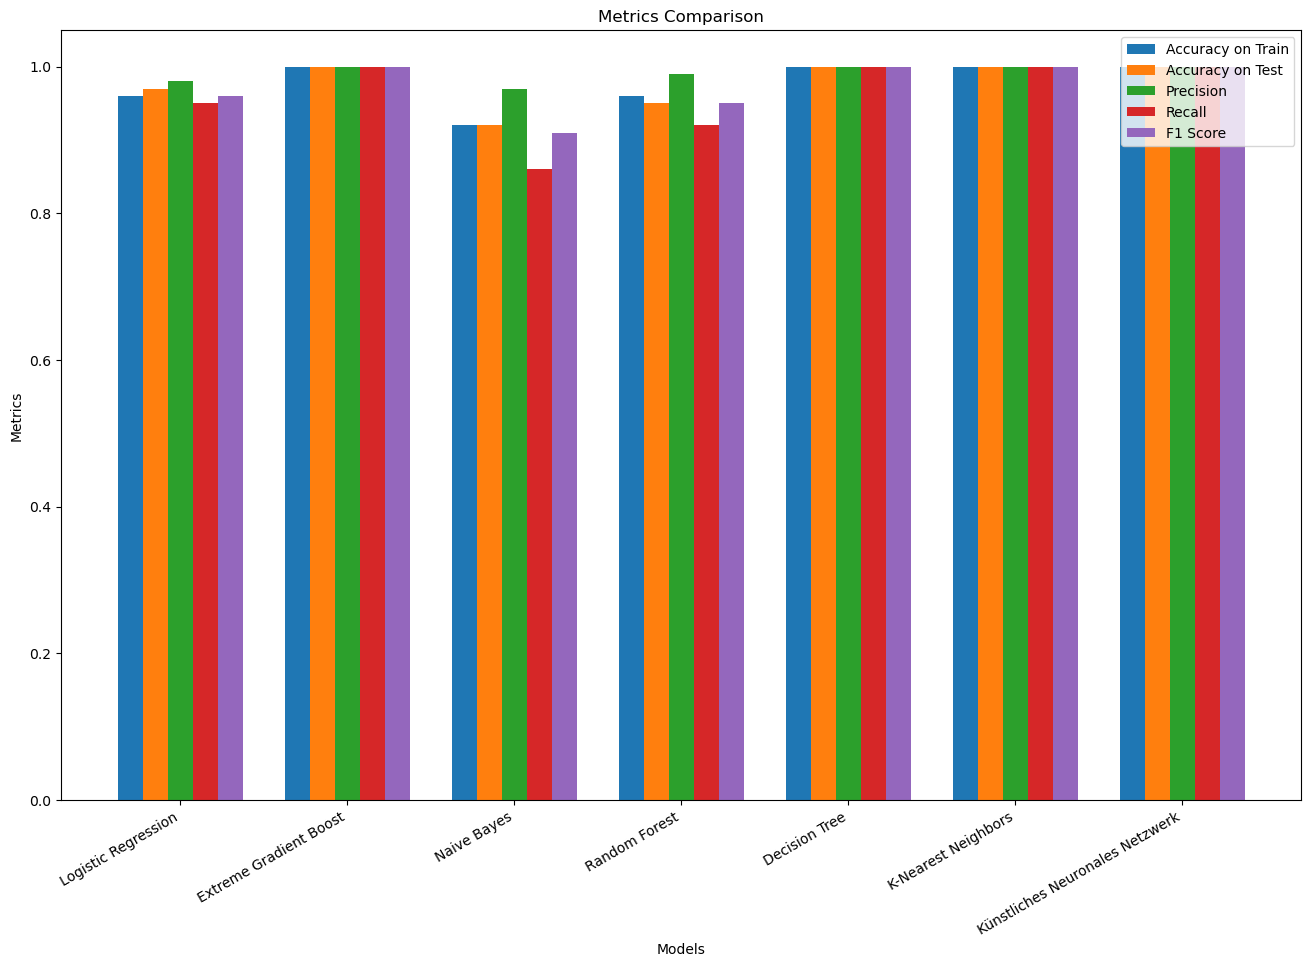

In [21]:
models = df_metrics['Model']
bar_width = 0.15
index = np.arange(len(models))

colors = plt.cm.tab10.colors

plt.figure(figsize=(16, 10))
plt.bar(index, df_metrics['Accuracy on Train'], bar_width, label='Accuracy on Train', color=colors[0])
plt.bar(index + bar_width, df_metrics['Accuracy on Test'], bar_width, label='Accuracy on Test', color=colors[1])
plt.bar(index + 2*bar_width, df_metrics['Precision'], bar_width, label='Precision', color=colors[2])
plt.bar(index + 3*bar_width, df_metrics['Recall'], bar_width, label='Recall', color=colors[3])
plt.bar(index + 4*bar_width, df_metrics['F1 Score'], bar_width, label='F1 Score', color=colors[4])

plt.xlabel('Models')
plt.ylabel('Metrics')
plt.title('Metrics Comparison')
plt.xticks(index + 2*bar_width, models, rotation=30, ha="right")
plt.legend()

plt.savefig(os.path.join("output", "metrics_comparison"))
plt.show()

### Darstellung der ROC-Kurve

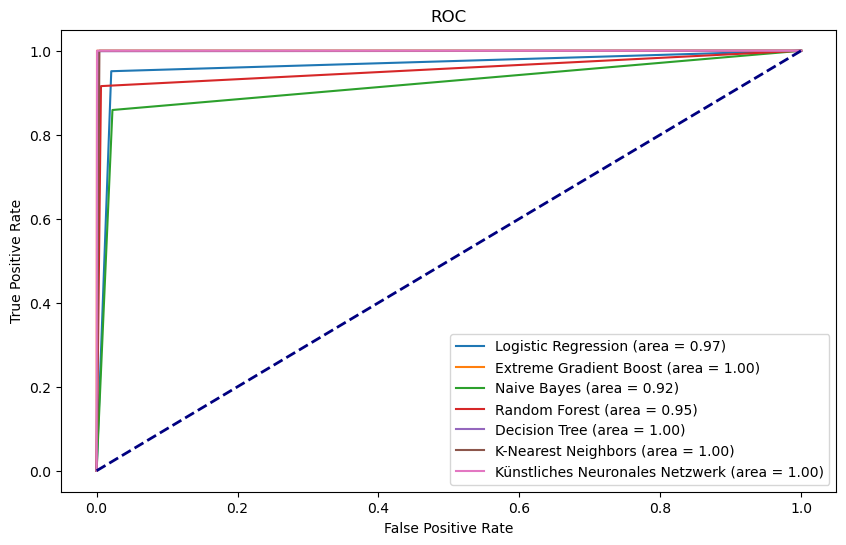

In [22]:
models = [
    ('Logistic Regression', lr, X_test, y_test, y_pred_lr),
    ('Extreme Gradient Boost', xgb, X_test, y_test, y_pred_xgb),
    ('Naive Bayes', nb, X_test, y_test, y_pred_nb),
    ('Random Forest', rf, X_test, y_test, y_pred_rf),
    ('Decision Tree', dt, X_test, y_test, y_pred_dt),
    ('K-Nearest Neighbors', knn, X_test, y_test, y_pred_knn),
    ('Künstliches Neuronales Netzwerk', mlp, X_test, y_test, y_pred_mlp)
]

plt.figure(figsize=(10, 6))

for model_name, model, X_test, y_test, y_pred in models:
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

## Modelltests mit reduzierten Features

### Identifikation der besten 10 und der besten 5 Features (anhand der XG Boost Feature Importance)

In [23]:
features_sorted = xgbfeatures.sort_values(by='Importance', ascending=False)
features_sorted.to_csv(os.path.join("output", "xgb_feature_importance_in_order.csv"))
print(features_sorted)

   Feature  Importance
13     V14    0.669634
3       V4    0.057082
11     V12    0.025020
7       V8    0.021053
2       V3    0.018148
0       V1    0.017849
9      V10    0.015765
1       V2    0.012609
16     V17    0.012184
22     V23    0.011441
12     V13    0.011240
10     V11    0.010543
6       V7    0.009712
17     V18    0.009686
19     V20    0.008936
8       V9    0.008432
5       V6    0.007835
25     V26    0.007657
27     V28    0.007443
24     V25    0.007324
15     V16    0.006925
21     V22    0.006911
18     V19    0.006618
26     V27    0.006565
23     V24    0.006026
4       V5    0.005858
14     V15    0.005615
20     V21    0.005415
28  Amount    0.000471


### Entfernen von Features und Modellvorbereitung

In [24]:
# top10 = top 10 features
# top5 = top 5 features
df_top10 = df[['V14', 'V4', 'V12', 'V8', 'V3', 'V1', 'V10', 'V2', 'V17', 'V23', 'Amount', 'Class']]
df_top5 = df[['V14', 'V4', 'V12', 'V8', 'V3', 'Amount', 'Class']]

y_top10 = df_top10['Class']
X_top10 = df_top10.drop('Class', axis=1)
X_train_top10, X_test_top10, y_train_top10, y_test_top10 = train_test_split(X_top10, y_top10, test_size=0.20, shuffle=True, stratify=y_top10, random_state=304)

scaler = StandardScaler()
X_train_top10 = scaler.fit_transform(X_train_top10)
X_test_top10 = scaler.transform(X_test_top10)

y_top5 = df_top5['Class']
X_top5 = df_top5.drop('Class', axis=1)
X_train_top5, X_test_top5, y_train_top5, y_test_top5 = train_test_split(X_top5, y_top5, test_size=0.20, shuffle=True, stratify=y_top5, random_state=304)

scaler = StandardScaler()
X_train_top5 = scaler.fit_transform(X_train_top5)
X_test_top5 = scaler.transform(X_test_top5)

### Beispielhafte Anwendung auf Modelle

#### LogisticRegression - Top 10

Accuracy on training set: 0.9580219123155654
Accuracy on test set: 0.9572920880009849
Precision: 0.9764897749761783
Recall: 0.9371471783057524
F1-Score: 0.9564140530354018
ROC-AUC: 0.9572920880009848
Confusion matrix, without normalization
[[55580  1283]
 [ 3574 53289]]
Normalized confusion matrix
[[0.98 0.02]
 [0.06 0.94]]


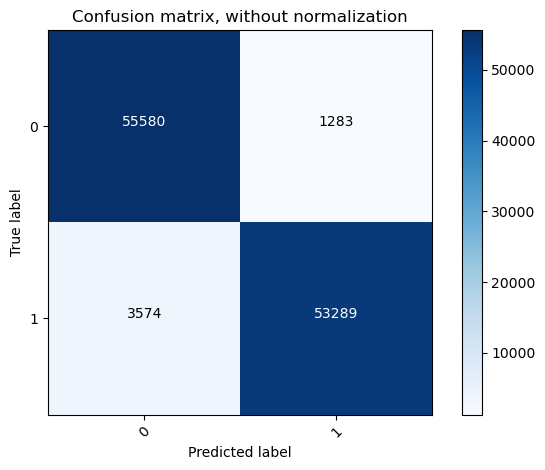

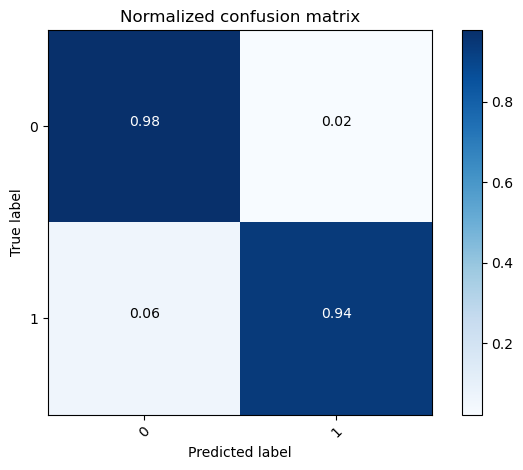

In [25]:
# top10 = top 10 features
lr_top10 = LogisticRegression(random_state=304)
model_lr_top10 = lr_top10.fit(X_train_top10, y_train_top10)
y_pred_lr_top10 = lr_top10.predict(X_test_top10)

lr_top10_metrics = evaluate_model(model_lr_top10, X_test_top10, X_train_top10, y_train_top10, y_test_top10, y_pred_lr_top10)
print_metrics(lr_top10_metrics)

lr_top10_cnf_matrix = confusion_matrix(y_test_top5, y_pred_lr_top10)

plt.figure()
plot_confusion_matrix(lr_top10_cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, without normalization')
plt.savefig(os.path.join("output", "confusion_matrix_lr_top10"))
# With normalization
plt.figure()
plot_confusion_matrix(lr_top10_cnf_matrix, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')
plt.savefig(os.path.join("output", "confusion_matrix_lr_top10_normalized"))
plt.show()

#### LogisticRegression - Top 5

Accuracy on training set: 0.9546036086734784
Accuracy on test set: 0.9538452069007967
Precision: 0.9707073286396964
Recall: 0.9359337354694617
F1-Score: 0.9530034291649133
ROC-AUC: 0.9538452069007967
Confusion matrix, without normalization
[[55257  1606]
 [ 3643 53220]]
Normalized confusion matrix
[[0.97 0.03]
 [0.06 0.94]]


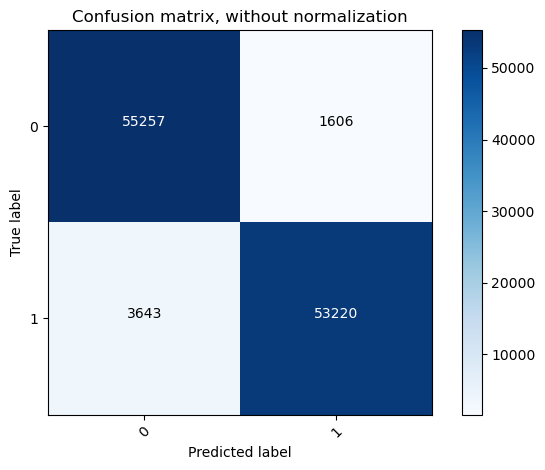

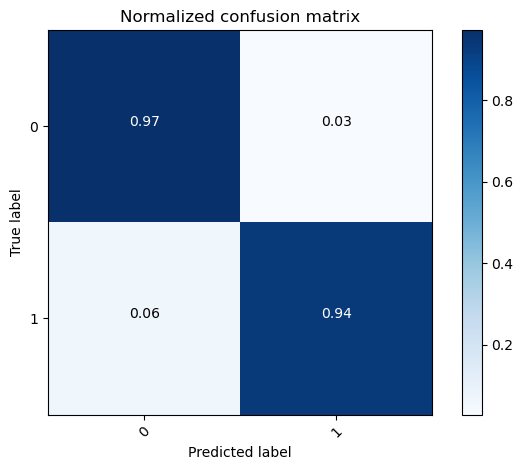

In [26]:
# top5 = top 5 features
lr_top5 = LogisticRegression(random_state=304)
model_lr_top5 = lr_top5.fit(X_train_top5, y_train_top5)
y_pred_lr_top5 = lr_top5.predict(X_test_top5)

lr_top5_metrics = evaluate_model(model_lr_top5, X_test_top5, X_train_top5, y_train_top5, y_test_top5, y_pred_lr_top5)
print_metrics(lr_top5_metrics)

lr_top5_cnf_matrix = confusion_matrix(y_test_top5, y_pred_lr_top5)

plt.figure()
plot_confusion_matrix(lr_top5_cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, without normalization')
plt.savefig(os.path.join("output", "confusion_matrix_lr_top5"))
# With normalization
plt.figure()
plot_confusion_matrix(lr_top5_cnf_matrix, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')
plt.savefig(os.path.join("output", "confusion_matrix_lr_top5_normalized"))
plt.show()

#### Extreme Gradient Boost - Top 10

Accuracy on training set: 0.9993185375375904
Accuracy on test set: 0.9986106958830874
Precision: 0.9977353720836333
Recall: 0.9994900022861967
F1-Score: 0.9986119164338552
ROC-AUC: 0.9986106958830875
Confusion matrix, without normalization
[[56734   129]
 [   29 56834]]
Normalized confusion matrix
[[9.98e-01 2.27e-03]
 [5.10e-04 9.99e-01]]


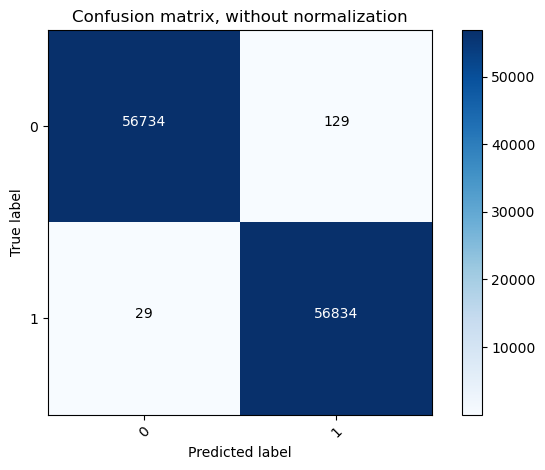

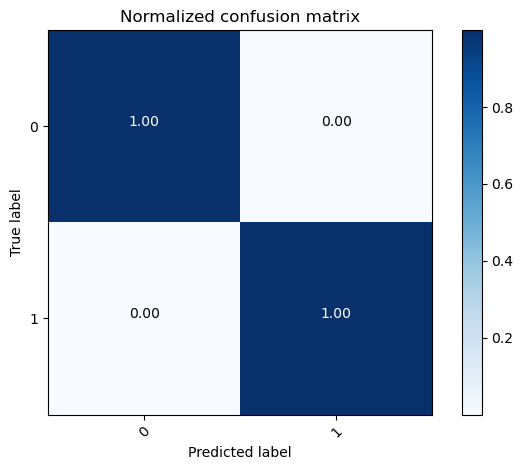

In [27]:
# top10 = top 10 features
xgb_top10 = XGBClassifier(random_state=304)
model_xgb_top10 = xgb_top10.fit(X_train_top10, y_train_top10)
y_pred_xgb_top10 = xgb_top10.predict(X_test_top10)

xgb_top10_metrics = evaluate_model(model_xgb_top10, X_test_top10, X_train_top10, y_train_top10, y_test_top10, y_pred_xgb_top10)
print_metrics(xgb_top10_metrics)

xgb_top10_cnf_matrix = confusion_matrix(y_test_top10, y_pred_xgb_top10)

plt.figure()
plot_confusion_matrix(xgb_top10_cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, without normalization')
plt.savefig(os.path.join("output", "confusion_matrix_xgb_top10"))
# With normalization
plt.figure()
plot_confusion_matrix(xgb_top10_cnf_matrix, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')
plt.savefig(os.path.join("output", "confusion_matrix_xgb_top10_normalized"))
plt.show()

#### Extreme Gradient Boost - Top 5

Accuracy on training set: 0.990855213407664
Accuracy on test set: 0.9885690167595801
Precision: 0.9893780056016488
Recall: 0.9877424687406574
F1-Score: 0.9885595606871305
ROC-AUC: 0.9885690167595801
Confusion matrix, without normalization
[[56260   603]
 [  697 56166]]
Normalized confusion matrix
[[0.99 0.01]
 [0.01 0.99]]


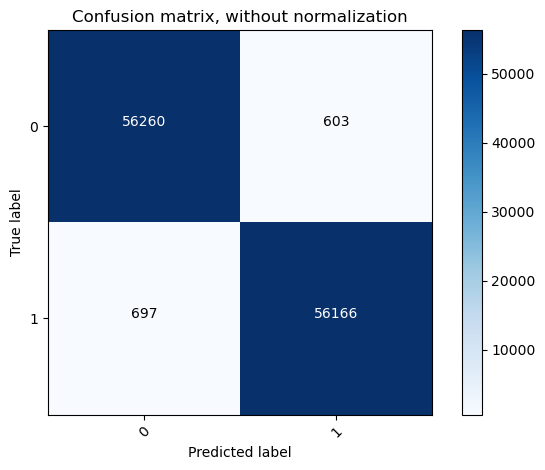

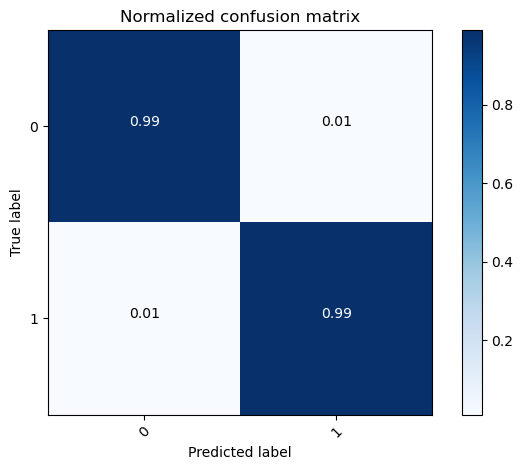

In [28]:
# top5 = top 5 features
xgb_top5 = XGBClassifier(random_state=304)
model_xgb_top5 = xgb_top5.fit(X_train_top5, y_train_top5)
y_pred_xgb_top5 = xgb_top5.predict(X_test_top5)

xgb_top5_metrics = evaluate_model(model_xgb_top5, X_test_top5, X_train_top5, y_train_top5, y_test_top5, y_pred_xgb_top5)
print_metrics(xgb_top5_metrics)

xgb_top5_cnf_matrix = confusion_matrix(y_test_top5, y_pred_xgb_top5)

plt.figure()
plot_confusion_matrix(xgb_top5_cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, without normalization')
plt.savefig(os.path.join("output", "confusion_matrix_xgb_top5"))
# With normalization
plt.figure()
plot_confusion_matrix(xgb_top5_cnf_matrix, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')
plt.savefig(os.path.join("output", "confusion_matrix_xgb_top5_normalized"))
plt.show()

### Vergleich von allen Features mit weniger Features

In [29]:
df_metrics_feature_amount = pd.DataFrame({
    'Model': [
        'Logistic Regression - all 28 Features', 
        'Logistic Regression - top 10 Features', 
        'Logistic Regression - top 5 Features',
        'Extreme Gradient Boost - all 28 Features', 
        'Extreme Gradient Boost - top 10 Features', 
        'Extreme Gradient Boost - top 5 Features'
    ],
    'Accuracy on Train': [lr_metrics['Accuracy on train'], lr_top10_metrics['Accuracy on train'], lr_top5_metrics['Accuracy on train'], xgb_metrics['Accuracy on train'], xgb_top10_metrics['Accuracy on train'], xgb_top5_metrics['Accuracy on train']],
    'Accuracy on Test': [lr_metrics['Accuracy on test'], lr_top10_metrics['Accuracy on test'], lr_top5_metrics['Accuracy on test'], xgb_metrics['Accuracy on test'], xgb_top10_metrics['Accuracy on test'], xgb_top5_metrics['Accuracy on test']],
    'Precision': [lr_metrics['Precision'], lr_top10_metrics['Precision'], lr_top5_metrics['Precision'], xgb_metrics['Precision'], xgb_top10_metrics['Precision'], xgb_top5_metrics['Precision']],
    'Recall': [lr_metrics['Recall'], lr_top10_metrics['Recall'], lr_top5_metrics['Recall'], xgb_metrics['Recall'], xgb_top10_metrics['Recall'], xgb_top5_metrics['Recall']],
    'F1 Score': [lr_metrics['F1 Score'], lr_top10_metrics['F1 Score'], lr_top5_metrics['F1 Score'], xgb_metrics['F1 Score'], xgb_top10_metrics['F1 Score'], xgb_top5_metrics['F1 Score']]
})

df_metrics_feature_amount = df_metrics_feature_amount.round(2)

print(df_metrics_feature_amount)
df_metrics_feature_amount.to_csv(os.path.join("output", "metrics_comparison_reduced_features.csv"))

                                      Model  Accuracy on Train  \
0     Logistic Regression - all 28 Features               0.96   
1     Logistic Regression - top 10 Features               0.96   
2      Logistic Regression - top 5 Features               0.95   
3  Extreme Gradient Boost - all 28 Features               1.00   
4  Extreme Gradient Boost - top 10 Features               1.00   
5   Extreme Gradient Boost - top 5 Features               0.99   

   Accuracy on Test  Precision  Recall  F1 Score  
0              0.97       0.98    0.95      0.96  
1              0.96       0.98    0.94      0.96  
2              0.95       0.97    0.94      0.95  
3              1.00       1.00    1.00      1.00  
4              1.00       1.00    1.00      1.00  
5              0.99       0.99    0.99      0.99  


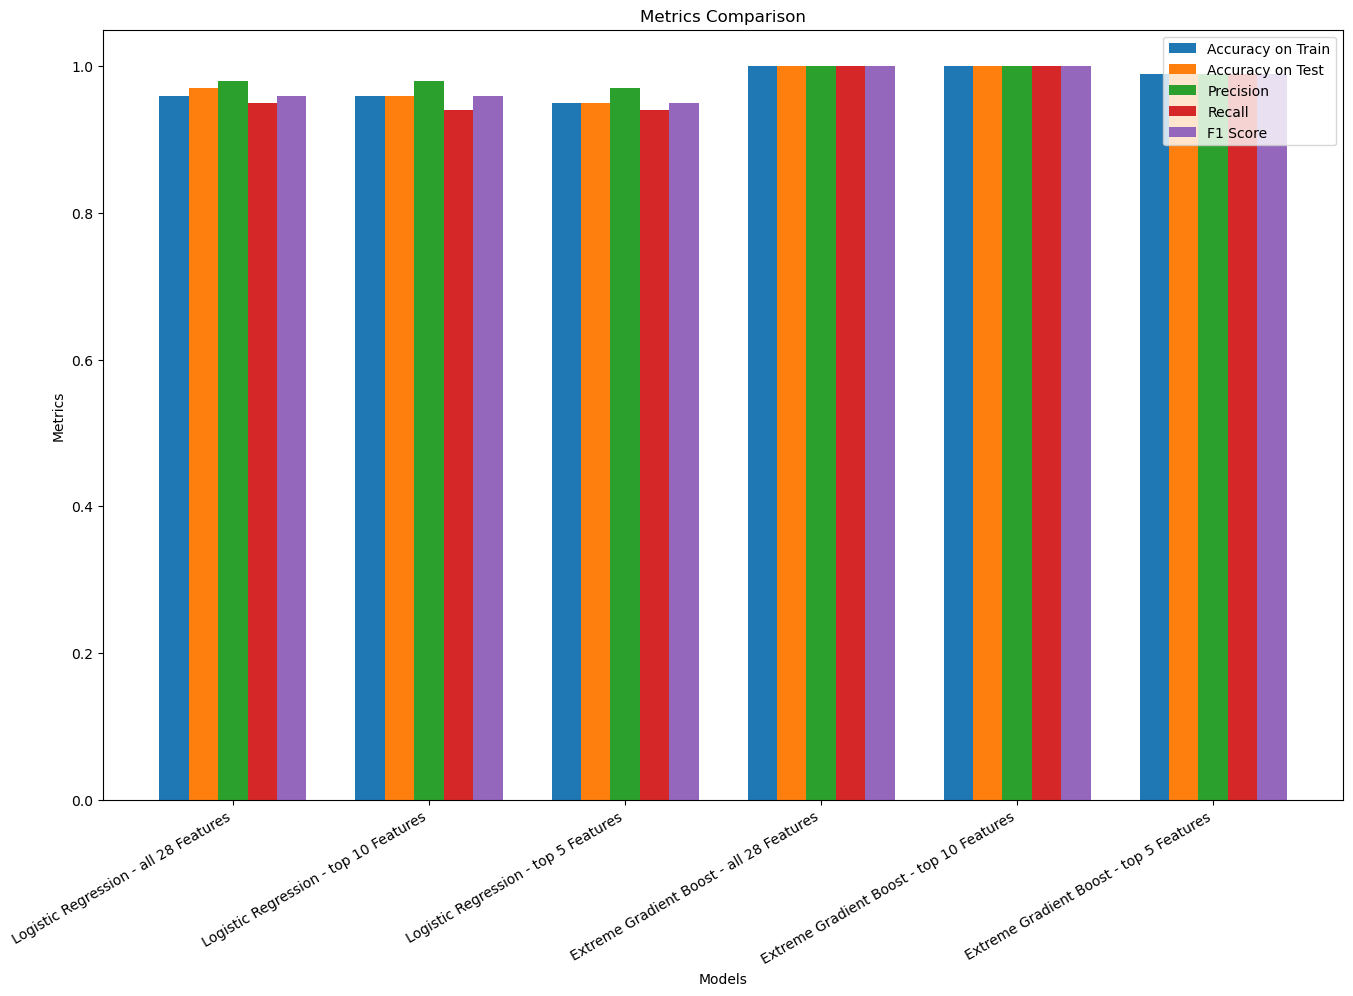

In [30]:
models_feature_amount = df_metrics_feature_amount['Model']
bar_width = 0.15
index = np.arange(len(models_feature_amount))

colors = plt.cm.tab10.colors

plt.figure(figsize=(16, 10))
plt.bar(index, df_metrics_feature_amount['Accuracy on Train'], bar_width, label='Accuracy on Train', color=colors[0])
plt.bar(index + bar_width, df_metrics_feature_amount['Accuracy on Test'], bar_width, label='Accuracy on Test', color=colors[1])
plt.bar(index + 2*bar_width, df_metrics_feature_amount['Precision'], bar_width, label='Precision', color=colors[2])
plt.bar(index + 3*bar_width, df_metrics_feature_amount['Recall'], bar_width, label='Recall', color=colors[3])
plt.bar(index + 4*bar_width, df_metrics_feature_amount['F1 Score'], bar_width, label='F1 Score', color=colors[4])

plt.xlabel('Models')
plt.ylabel('Metrics')
plt.title('Metrics Comparison')
plt.xticks(index + 2*bar_width, models_feature_amount, rotation=30, ha="right")
plt.legend()

plt.savefig(os.path.join("output", "metrics_comparison_reduced_features"))
plt.show()